In [1]:
%matplotlib inline

import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import pandas as pd
import progressbar
import os 

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm

import itertools
from collections import deque

import scipy.stats
import scipy.spatial.distance

import Data, Figures, Models

Data = reload(Data)
Figures = reload(Figures)
Models = reload(Models)

from IPython.display import display, HTML

figureOutputDir = "/home/caleb/Dropbox/CalebBistra/Papers/PNAS_2016/figures/"

In [2]:
shapefile = fiona.open("data/countyBoundaries/countyBoundaries2.shp", "r")
counties = list(shapefile)
shapefile.close()

src = rasterio.open("data/usRaster.tif")
noData = src.nodatavals
data = src.read()
src.close()

# rasterio returns a 3-dimensional array of shape (1,width,height), we need to remove the first axis to visualize
data = data.squeeze()

In [8]:
startSeaLevelRise = 0
stopSeaLevelRise = 10
seaLevelRiseRange = range(startSeaLevelRise,stopSeaLevelRise+1)

startYear = 2013
stopYear = 2013
yearRange = range(startYear,stopYear+1)


populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=False)
        
countyIds = Data.loadCounties()
countyIdMap = {countyId:i for i,countyId in enumerate(countyIds)} #mapping from countyId to position in list
countyIndex_IdMap = {i:countyId for i,countyId in enumerate(countyIds)}
countyNameMapping = Data.loadCountyNameMap() #mapping from countyId to name

distanceMatrix = Data.loadCountyPairwiseDistanceMatrix()

Loading the distance matrix


In [4]:
countyPopulationAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyLandAmountAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyTotalLand = []
percentLandAffected = []

countyNames = dict()
goodCounties = set()

bar = progressbar.ProgressBar()
for x in bar(seaLevelRiseRange):

    tempCountyPopulationAffected = dict()
    tempCountyLandAmountAffected = dict()
    tempCountyTotalLand = dict()
    totalLand = 0.0
    
    for county in counties:
        
        countyId = int(county["properties"]['GEOID'])
        countyName = countyNameMapping[countyId]
        if countyId in countyIds:
            try:
                geoms = [county["geometry"]]

                #src = rasterio.open("usRaster.tif")
                src = rasterio.open("outputs/mask_%d.tif" % (x))
                out_image, out_transform = mask(src, geoms, crop=True, nodata=-999)
                src.close()

                numZero = np.sum(out_image == -999.0)
                numAffected = np.sum(out_image == 1) #we marked raster as 1 if it was reachable by sea level rise
                numNotAffected = np.sum(out_image == 0)

                if x==0:
                    numNotAffected+=numAffected
                    numAffected=0
                
                assert numZero + numAffected + numNotAffected == out_image.count()

                totalNum = numAffected+numNotAffected

                percentAffected = (numAffected) / float(totalNum)
                totalLand += numAffected

                tempCountyPopulationAffected[countyId] = percentAffected
                tempCountyLandAmountAffected[countyId] = numAffected
                tempCountyTotalLand[countyId] = totalNum

                countyNames[countyId] = countyName
                goodCounties.add(countyId)
            except ValueError as e:
                pass
    
    countyPopulationAffected.append(tempCountyPopulationAffected) #TODO: fix this to be dict
    countyLandAmountAffected.append(tempCountyLandAmountAffected)
    countyTotalLand.append(tempCountyTotalLand)

100% (11 of 11) |##########################################################| Elapsed Time: 0:01:15 Time: 0:01:15


## Radiation Model Fit Parameters

In [9]:
fitParameters = [] #one for each year

for i,year in enumerate(yearRange):
    print "Calculating num migrants by population fit for %d" % (year)
    
    popVals = []
    exteriorMigrants = []
    interiorMigrants = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        exteriorMigrants.append(np.sum(migrationDataSets[i][j,:])-migrationDataSets[i][j,j])
        interiorMigrants.append(migrationDataSets[i][j,j])
        
    popVals = np.array(popVals)
    exteriorMigrants = np.array(exteriorMigrants)
    interiorMigrants = np.array(interiorMigrants)

    alpha = np.polyfit(popVals, exteriorMigrants, 1)[0]
    beta = np.polyfit(popVals, interiorMigrants, 1)[0]
    
    print alpha,beta
    
    fitParameters.append([alpha,beta])

Calculating num migrants by population fit for 2013
0.0313670997746 0.785373267073


## Radiation Model Unconstrained

In [10]:
radiationOutputsUnconstrained = []

for i,year in enumerate(yearRange):
    print "Running radiation model for year %d" % (year)
    
    tempRadiationOutputs = []
    alpha,beta = fitParameters[i]
    
    bar = progressbar.ProgressBar()
    for j,x in bar(list(enumerate(seaLevelRiseRange))):
        SLAi_over_Ai = countyPopulationAffected[j]
        
        SLAi_over_Ai_converted = []
        
        for k,countyId in enumerate(countyIds):
            if countyId in SLAi_over_Ai:
                SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
            else:
                SLAi_over_Ai_converted.append(0)
                
        T = Models.radiationModelImproved(populationDataSets[i], distanceMatrix, SLAi_over_Ai_converted, alpha, beta, countyIds)
        tempRadiationOutputs.append(T)
    radiationOutputsUnconstrained.append(tempRadiationOutputs)

Running radiation model for year 2013


100% (11 of 11) |##########################################################| Elapsed Time: 0:03:24 Time: 0:03:24


In [11]:
def radiationModelProbabilities(populationData, distanceMatrix, countyLandCoverPercentages, alpha, beta, countyIds):

    size = len(countyIds)
    outgoingMigrants = []
    odMatrix = np.zeros((size, size))
      
    n = len(countyIds)
    for i, k in enumerate(countyIds):
        currentPopulation = float(populationData[i])
        Ai = float(countyLandCoverPercentages[i])

        p = ((alpha+beta)*(1-Ai)*currentPopulation)+(Ai*currentPopulation)
        
        odMatrix[i][i] = 0
        
        #---------------------------------------------------
        #Handle exterior migrations
        
        #Step 1.) Sort counties by distance (closest to farthest away)
        otherPatches = []
        for j, k2 in enumerate(countyIds):
            otherPatches.append((distanceMatrix[i][j], j))
        otherPatches.sort(key=lambda x: x[0])   
        otherPatches = otherPatches[1:] #don't include self

        numberExteriorMigrants =  ((alpha)/(alpha+beta)) * p + ((beta)/(alpha+beta)) * Ai * p
        outgoingMigrants.append(numberExteriorMigrants)
        
        #Step 2.) Incrementally calculate the migrants to other counties
        S = 0
        for distance, j in otherPatches:
            otherPopulation = (1 - countyLandCoverPercentages[j]) * float(populationData[j])
            
            numerator = currentPopulation * otherPopulation
            denominator = (currentPopulation + S) * (currentPopulation + otherPopulation + S)
            
            #total = numberExteriorMigrants * (numerator / denominator)
            total = (numerator / denominator)

            odMatrix[i][j] = float(total)
            S += otherPopulation
    outgoingMigrants = np.array(outgoingMigrants)
    assert outgoingMigrants.shape[0] == odMatrix.shape[0]
    return outgoingMigrants,odMatrix

In [12]:
radiationOutputsProductionConstrainedProbabilities = []
radiationOutputsProductionConstrainedMigrants = []

for i,year in enumerate(yearRange):
    print "Running radiation model for year %d" % (year)
    
    tempRadiationOutputs = []
    tempPopulationOutputs = []
    alpha,beta = fitParameters[i]
    
    bar = progressbar.ProgressBar()
    for j,x in bar(list(enumerate(seaLevelRiseRange))):
        SLAi_over_Ai = countyPopulationAffected[j]
        
        SLAi_over_Ai_converted = []
        
        for k,countyId in enumerate(countyIds):
            if countyId in SLAi_over_Ai:
                SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
            else:
                SLAi_over_Ai_converted.append(0)
                
        Ti,Pij = radiationModelProbabilities(populationDataSets[i], distanceMatrix, SLAi_over_Ai_converted, alpha, beta, countyIds)
        tempRadiationOutputs.append(Pij)
        tempPopulationOutputs.append(Ti)
    radiationOutputsProductionConstrainedProbabilities.append(tempRadiationOutputs)
    radiationOutputsProductionConstrainedMigrants.append(tempPopulationOutputs)

Running radiation model for year 2013


100% (11 of 11) |##########################################################| Elapsed Time: 0:03:16 Time: 0:03:16


## Check Difference of CPC at Baseline

In [29]:
originalProbabilities = radiationOutputsProductionConstrainedProbabilities[0][0].copy()
rowSums = np.sum(originalProbabilities,axis=1)
print min(rowSums), max(rowSums)
newProbabilities = (originalProbabilities.T/rowSums).T
newRowSums = np.sum(newProbabilities,axis=1)
print min(newRowSums),max(newRowSums)

0.968258024274 0.999999742128
1.0 1.0


In [30]:
T_unconstrained = (radiationOutputsProductionConstrainedProbabilities[0][0].T * radiationOutputsProductionConstrainedMigrants[0][0]).T
T_unconstrained_rowSums = np.sum(T_unconstrained,axis=1)

In [32]:
T_production_constrained = (newProbabilities.T * radiationOutputsProductionConstrainedMigrants[0][0]).T
T_production_constrained_rowSums = np.sum(T_production_constrained,axis=1)

In [37]:
groundTruth = migrationDataSets[0].copy()
for i in range(groundTruth.shape[0]):
    groundTruth[i,i] = 0

In [38]:
def cpc(G,O):
    '''Calcuates the common part of commuters value between the generated matrix, G, and the observed matrix, O

    returns: The CPC value of the inputs
    '''
    assert len(G.shape) == 2 and len(O.shape) == 2
    assert G.shape[0] == O.shape[0] and G.shape[1] == O.shape[1]

    numerator = np.sum(np.minimum(G,O))
    denominator = np.sum(O)
    
    return float(numerator)/float(denominator)

In [39]:
print cpc(T_unconstrained,groundTruth)

0.550012830315


In [40]:
print cpc(T_production_constrained,groundTruth)

0.550918029572


## Check how unconstrained model messes up with SLR

In [41]:
xVals  = []
yVals1 = []
yVals2 = []

for i,slrAmount in enumerate(seaLevelRiseRange):
    print slrAmount
    
    xVals.append(slrAmount)
    
    originalProbabilities = radiationOutputsProductionConstrainedProbabilities[0][i].copy()
    rowSums = np.sum(originalProbabilities,axis=1)
    
    #yVals1.append(min(rowSums))
    #yVals2.append(max(rowSums))

    newProbabilities = (originalProbabilities.T/rowSums).T
    newRowSums = np.sum(newProbabilities,axis=1)

    T_unconstrained = (radiationOutputsProductionConstrainedProbabilities[0][i].T * radiationOutputsProductionConstrainedMigrants[0][i]).T
    T_unconstrained_rowSums = np.sum(T_unconstrained,axis=1)
    
    T_production_constrained = (newProbabilities.T * radiationOutputsProductionConstrainedMigrants[0][i]).T
    T_production_constrained_rowSums = np.sum(T_production_constrained,axis=1)
    
    print sorted(T_production_constrained_rowSums-T_unconstrained_rowSums, reverse=True)[:10]
    
    yVals1.append(np.sum(T_production_constrained_rowSums-T_unconstrained_rowSums))
    yVals2.append(max(T_production_constrained_rowSums-T_unconstrained_rowSums))

0
[9927.1016899321694, 2734.2875416717725, 1814.3612818529073, 1554.4954670534498, 1012.6000506774144, 953.07357646059245, 680.87719710783858, 661.62297943692829, 602.57055563521862, 519.1481289704243]
1
[10631.226470403664, 3735.8181563161779, 2898.7909511972684, 2773.7107030391926, 1908.3601560119423, 1576.9082984432025, 1218.5944689858006, 1172.9556342182186, 1008.7797265728732, 883.45048978389241]
2
[10783.374334483466, 4664.5669101546519, 3907.4422159281094, 2791.0816851061536, 2315.5387143118714, 1721.3926779390895, 1586.7840384558222, 1214.4599845287594, 1156.1025855391345, 1125.0326886230469]
3
[10930.269361184968, 5853.5074071243871, 4557.9787313627312, 2806.8276942654338, 2412.8558959323855, 1854.8372678493615, 1670.6286974043469, 1595.7359498730511, 1335.1855179710838, 1267.7155044892424]
4
[11197.234695443709, 8088.6516157749575, 7297.087987862411, 5218.0966733047972, 2835.1950415522151, 2700.692315335531, 2009.5409717320581, 1611.8633366593713, 1453.1617781414534, 1407.147

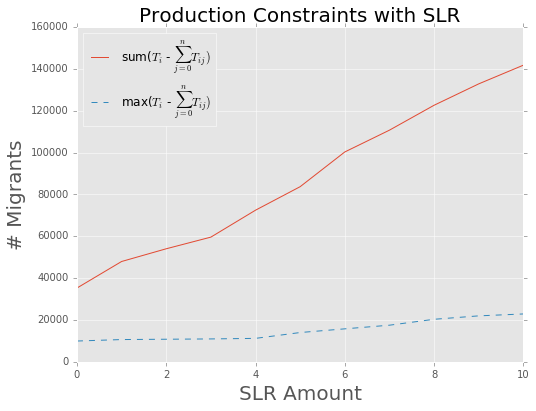

In [54]:
plt.figure(figsize=(8,6))
plt.title("Production Constraints with SLR",size=20)
plt.plot(xVals,yVals1,label="sum($T_i$ - $\sum_{j=0}^n T_{ij})$")
plt.plot(xVals,yVals2,linestyle="--",label="max($T_i$ - $\sum_{j=0}^n T_{ij})$")
plt.legend(loc="upper left")
plt.xlabel("SLR Amount",size=20)
plt.ylabel("# Migrants",size=20)
plt.show()